In [1]:
#######################################################################################
# Read Me Section:
## Name:
# Kaylen Smith Darnbrook
# Student ID:
# 2135667
# Course:
# M.S.c Machine Learning and Artificial Intelligence
# Module:
## FaceGeneration and Analysis:
## Description: 
# This module is repsonsible for the creation and testing of 
# the Dynamic UNet, a convolutional UNet which makes use of Convolution layers. 
#####################################################################################

In [2]:
# Import Relevant Libraries:
!pip install wandb
!pip install lpips
# Import modules for system managment, io and file management 
import os 
import random

# Import modules for data manipulation and analysis
import numpy as np
import pandas as pd
import scipy as sp

# Import modules for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook")
from PIL import Image

# Import modules for Deep learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
torch.set_float32_matmul_precision('medium')
torch.autograd.set_detect_anomaly(True)

# Pytorch Lightning Modules:
import pytorch_lightning as pL
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.callbacks import LearningRateMonitor

# Import modules for model selection and evaluation.

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Import the DataLoader
#from BinomDataset4 import FacesDataset
from PoissonDataset10 import FacesDataset
from PoissonValidator2 import ValidationSetGenerator

import wandb 
from pytorch_lightning.loggers import WandbLogger
from inference2 import sample_image_3

# Visualisation Software
import numpy as np
import lpips

In [3]:
def Sample_Image(input_image, model,  max_psnr, max_its = 1000, beta = 0.005, save_every_n = 10, device = 'cuda'):
    channels = 3
    batch_size = 1
    pixels_x = 128
    pixels_y = 128

    model = model.to(device)
    model.eval()
    input_image = input_image.to(device)

    denoised, photons, stack, i = sample_image_3(input_image, model, max_its = max_its, max_psnr = max_psnr, 
                                                 beta = beta, save_every_n = save_every_n)
    return denoised, photons, stack, i

In [4]:
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "red"
plt.rc("text", usetex = False)
plt.rc("font", family = "Times New Roman")
plt.rcParams["axes.grid"] = False

In [5]:
## Configuration
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
GREYSCALE = False

# Set the path to the data
root_path = r"ffhq256_dataset/ffhq256"  # Replace with the Directory the FFHQ256 dataset is stored in
out_dir =r"TestSet"  # Replace with the Directory to save the generated images
Batch_Size = 32
load_pretained = False
NUM_Features = 128 * 128
max_epochs = 50
patience = 10
minpsnr = -40
maxpsnr = 32

Device: cuda


In [6]:
from IPython.display import display
def Plot_Creater(Psnr_Distribution, SSIM_Distribution, Perceptual_Distribution, minpsnr, maxpsnr):

    Psnr_Distribution = pd.DataFrame(Psnr_Distribution, columns = ["PSNR"])
    Psnr_Distribution["Pseudo_PSNR"] = np.linspace(minpsnr, maxpsnr, Psnr_Distribution.shape[0])
    Psnr_Distribution["PSNR_Average"] = Psnr_Distribution["PSNR"].rolling(window = 12).mean()
    Psnr_Distribution["PSNR_Variance"] = Psnr_Distribution["PSNR"].rolling(window = 12).std()
    Psnr_Distribution["PSNR_Variance_Upper"] = Psnr_Distribution["PSNR_Average"] + Psnr_Distribution["PSNR"].rolling(window = 12).std()
    Psnr_Distribution["PSNR_Variance_Lower"] = Psnr_Distribution["PSNR_Average"] - Psnr_Distribution["PSNR"].rolling(window = 12).std()   
    Psnr_Distribution.dropna(inplace = True)
    display(Psnr_Distribution.describe())

    SSIM_Distribution = pd.DataFrame(SSIM_Distribution, columns = ["SSIM"])
    SSIM_Distribution["Pseudo_PSNR"] = np.linspace(minpsnr, maxpsnr, SSIM_Distribution.shape[0])
    SSIM_Distribution["SSIM_Average"] = SSIM_Distribution["SSIM"].rolling(window = 12).mean()
    SSIM_Distribution["SSIM_Variance"] = SSIM_Distribution["SSIM"].rolling(window = 12).std()
    SSIM_Distribution["SSIM_Variance_Upper"] = SSIM_Distribution["SSIM_Average"] + SSIM_Distribution["SSIM"].rolling(window = 12).std()
    SSIM_Distribution["SSIM_Variance_Lower"] = SSIM_Distribution["SSIM_Average"] - SSIM_Distribution["SSIM"].rolling(window = 12).std()
    SSIM_Distribution.dropna(inplace = True)
    display(SSIM_Distribution.describe())

    Perceptual_Distribution = pd.DataFrame(Perceptual_Distribution, columns = ["1-PL"])
    Perceptual_Distribution["Pseudo_PSNR"] = np.linspace(minpsnr, maxpsnr, Perceptual_Distribution.shape[0])
    Perceptual_Distribution["1-PL_Average"] = Perceptual_Distribution["1-PL"].rolling(window = 12).mean()
    Perceptual_Distribution["1-PL_Variance"] = Perceptual_Distribution["1-PL"].rolling(window = 12).std()
    Perceptual_Distribution["1-PL_Variance_Upper"] = Perceptual_Distribution["1-PL_Average"] + Perceptual_Distribution["1-PL_Average"].rolling(window = 12).std()
    Perceptual_Distribution["1-PL_Variance_Lower"] = Perceptual_Distribution["1-PL_Average"] - Perceptual_Distribution["1-PL_Average"].rolling(window = 12).std()
    Perceptual_Distribution.dropna(inplace = True)
    display(Perceptual_Distribution.describe())

    plt.Figure(figsize=(10,10))
    sns.set_style("darkgrid")
    sns.scatterplot(data = Psnr_Distribution, x = "Pseudo_PSNR", y = "PSNR", alpha = 0.5)
    sns.lineplot(data = Psnr_Distribution, x = "Pseudo_PSNR", y = "PSNR_Average", color = "red")
    sns.lineplot(data = Psnr_Distribution, x = "Pseudo_PSNR", y = "PSNR_Variance_Upper", color = "blue")
    sns.lineplot(data = Psnr_Distribution, x = "Pseudo_PSNR", y = "PSNR_Variance_Lower", color = "green")
    Psnr_Area = np.trapz(Psnr_Distribution["PSNR_Average"].values, Psnr_Distribution["Pseudo_PSNR"].values)
    #plt.fill_between(Psnr_Distribution_1["Pseudo_PSNR"].values, Psnr_Distribution_1["PSNR"].values, color='skyblue', alpha=0.4)  # Optional: Fill under the curve
    plt.xlabel("Pseudo_Psnr")
    plt.ylabel("PSNR")
    plt.title("Psnr vs Pseudo_Psnr")
    plt.show()

    plt.Figure(figsize=(10,10))
    sns.set_style("darkgrid")
    sns.scatterplot(data = SSIM_Distribution, x = "Pseudo_PSNR", y = "SSIM", alpha = 0.5)
    sns.lineplot(data = SSIM_Distribution, x = "Pseudo_PSNR", y = "SSIM_Average", color = "red")
    sns.lineplot(data = SSIM_Distribution, x = "Pseudo_PSNR", y = "SSIM_Variance_Upper", color = "blue")
    sns.lineplot(data = SSIM_Distribution, x = "Pseudo_PSNR", y = "SSIM_Variance_Lower", color = "green")
    SSIM_Area = np.trapz(SSIM_Distribution["SSIM_Average"].values, SSIM_Distribution["Pseudo_PSNR"].values)
    #plt.fill_between(Psnr_Distribution_1["Pseudo_PSNR"].values, Psnr_Distribution_1["PSNR"].values, color='skyblue', alpha=0.4)  # Optional: Fill under the curve
    plt.xlabel("Pseudo_Psnr")
    plt.ylabel("SSIM")
    plt.title("SSIM vs Pseudo_Psnr")
    plt.show()

    plt.Figure(figsize=(10,10))
    sns.scatterplot(data = Perceptual_Distribution, x = "Pseudo_PSNR", y = "1-PL", alpha = 0.5)
    sns.lineplot(data = Perceptual_Distribution, x = "Pseudo_PSNR", y = "1-PL_Average", color = "red") 
    sns.lineplot(data = Perceptual_Distribution, x = "Pseudo_PSNR", y = "1-PL_Variance_Upper", color = "blue")
    sns.lineplot(data = Perceptual_Distribution, x = "Pseudo_PSNR", y = "1-PL_Variance_Lower", color = "green")
    Perceptual_Area = np.trapz(Perceptual_Distribution["1-PL_Average"].values, Perceptual_Distribution["Pseudo_PSNR"].values)
    #plt.fill_between(Psnr_Distribution_1["Pseudo_PSNR"].values, Psnr_Distribution_1["PSNR"].values, color='skyblue', alpha=0.4)  # Optional: Fill under the curve
    plt.xlabel("Pseudo_Psnr")
    plt.ylabel("1-Perceptual_Loss")
    plt.title("1-Perceptual_Loss vs Pseudo_Psnr")
    plt.show()

    print(f"Psnr Area: {Psnr_Area}, SSIM Area: {SSIM_Area}, Perceptual Area: {Perceptual_Area}")

    print("Mean Psnr",Psnr_Distribution["PSNR"].mean())
    print("Std Psnr",Psnr_Distribution["PSNR"].std()) 
    print("Min Psnr",Psnr_Distribution["PSNR"].min()) 
    print("Max Psnr",Psnr_Distribution["PSNR"].max())
    print("Mean Roll Var",Psnr_Distribution["PSNR_Variance"].mean())

    print("Mean SSIM",SSIM_Distribution["SSIM"].mean())
    print("Std SSIM",SSIM_Distribution["SSIM"].std()) 
    print("Min SSIM",SSIM_Distribution["SSIM"].min()) 
    print("Max SSIM",SSIM_Distribution["SSIM"].max())
    print("Mean Roll SSIM",SSIM_Distribution["SSIM_Variance"].mean())

    print("Mean 1-PL",Perceptual_Distribution["1-PL"].mean())
    print("Std 1-PL",Perceptual_Distribution["1-PL"].std()) 
    print("Min 1-PL",Perceptual_Distribution["1-PL"].min()) 
    print("Max 1-PL",Perceptual_Distribution["1-PL"].max())
    print("Mean Roll 1-PL",Perceptual_Distribution["1-PL_Variance"].mean())

    return Psnr_Area, SSIM_Area, Perceptual_Area

In [7]:
Steps = 9
Spacing = (maxpsnr - minpsnr) // Steps
PSNR_Ranges = [(i, j) for i, j in zip(range(minpsnr, maxpsnr, Spacing), range(minpsnr + Spacing, maxpsnr + Spacing, Spacing))]
print(PSNR_Ranges)

[(-40, -32), (-32, -24), (-24, -16), (-16, -8), (-8, 0), (0, 8), (8, 16), (16, 24), (24, 32)]


In [8]:
def PSNR(original, transformed, maximum):
    mse = np.mean((original-transformed)**2)
    if mse == 0:
        return 100
    max_pixel_value = maximum
    psnr = 20 * np.log10(max_pixel_value/np.sqrt(mse))
    return psnr

def SSIM(original, transformed):
    return sp.signal.ssim(original, transformed, multichannel=True)

def Psuedo_PSNR(original, transformed, image_size, maximum):
    mse = np.mean((original-transformed)**2)
    intensity = transformed/image_size
    if intensity == 0 or mse == 0:
        return 100
    max_pixel = maximum
    signal_score = intensity * image_size * original
    psnr = 20 * np.log(signal_score/np.sqrt(mse))
    return psnr

def Estimated_Psuedo_PSNR(transformed, image_size):
    intensity = transformed/image_size
    return 10 * np.log(intensity)

In [9]:
def plot_random_persons(images, sample = 9):
    random_image_indexes=np.array(random.sample(list(range(len(images))),sample))
    images = np.array([np.asarray(Image.open(os.path.join(root_path, images[index]))) for index in random_image_indexes])

    if (np.sqrt(sample) - int(np.sqrt(sample))) == 0:
        sqrt = int(np.sqrt(sample))
        Length, width = sqrt, sqrt
    else:
        Length, width = 1, sample
    
    fig = plt.figure(figsize=(15,15))
    for index, values in enumerate(random_image_indexes):
        images = np.array(images)
        image = (images[index] - images[index].min())/(images[index].max() - images[index].min())
        plt.subplot(Length,width,index+1)
        plt.imshow(image)
        plt.title(f'Person_id: {random_image_indexes[index]}\nShape: {images[index].shape}')
    return fig

37621.png
70000


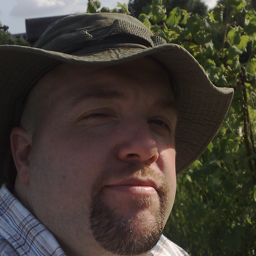

In [10]:
Image_Paths = [img for img in os.listdir(root_path)]
print(Image_Paths[0])
print(len(Image_Paths ))
Image.open(os.path.join(root_path, Image_Paths[50128]))

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

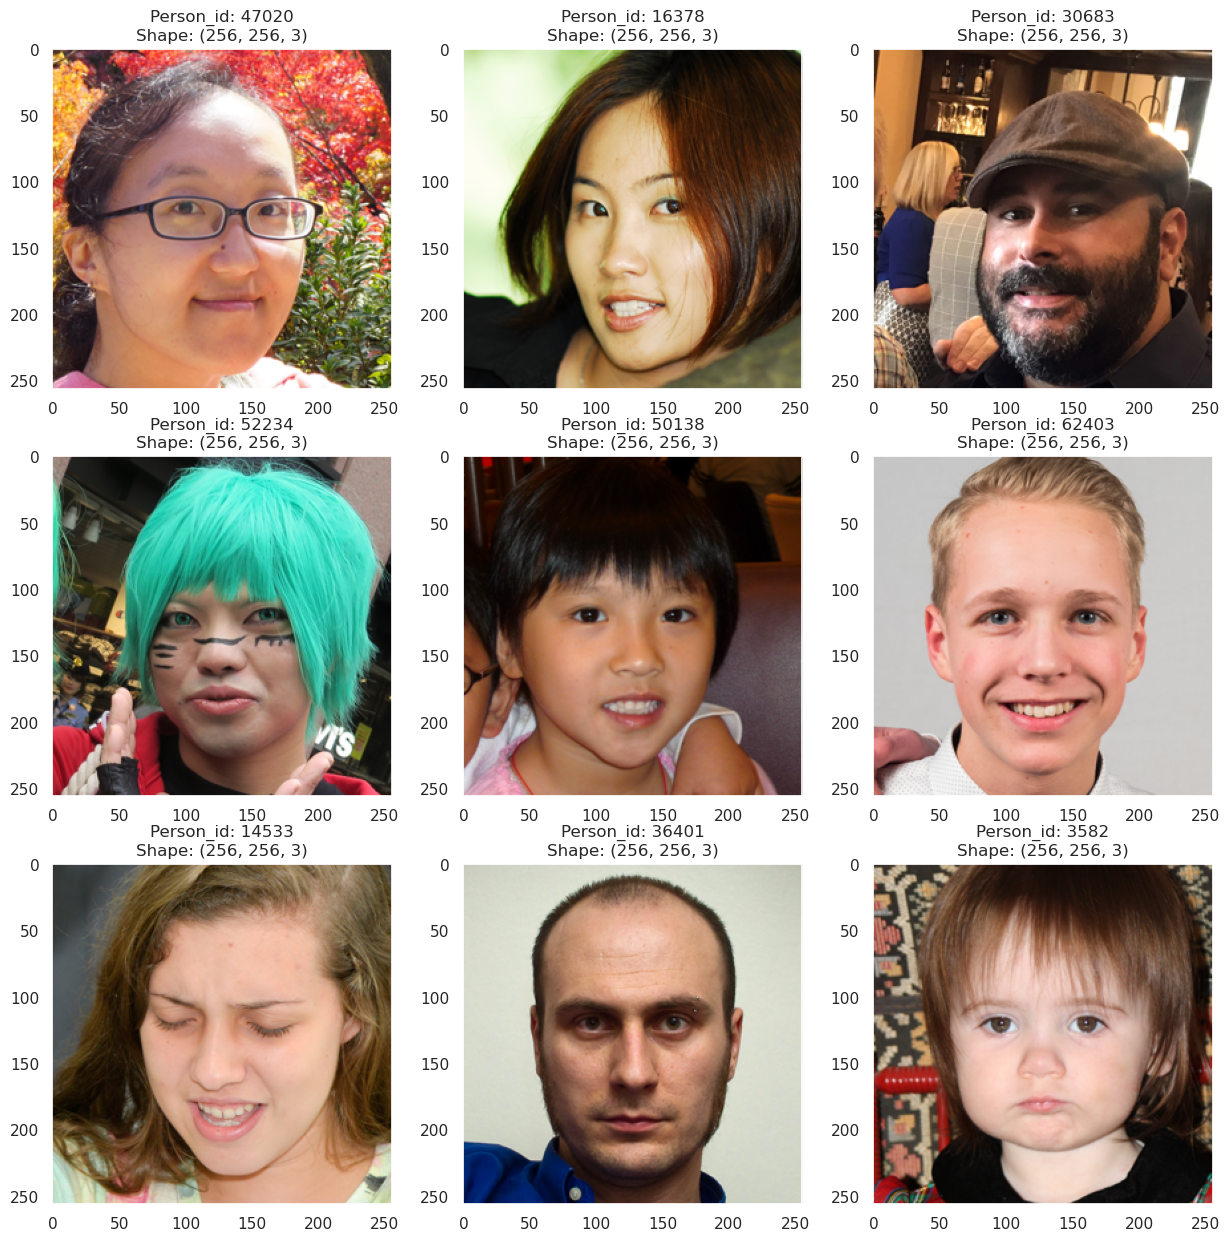

In [11]:
Image_Paths = [img for img in os.listdir(root_path)]
fig = plot_random_persons(Image_Paths, sample = 9)

In [12]:
Directory = [path for path in os.listdir(root_path)]
rng = np.random.default_rng(seed)
indices = rng.permutation(len(Directory))
split_index = int(len(Directory) * 0.8)
train_indices = indices[:split_index]
val_indices = indices[split_index:]
train_indices.shape, val_indices.shape

((56000,), (14000,))

In [13]:
Train_Paths = [Directory[index] for index in train_indices]
Val_Paths = [Directory[index] for index in val_indices]
Paths = Train_Paths.copy()
Paths.extend(Val_Paths)
np.shape(Train_Paths), np.shape(Val_Paths), np.shape(Paths)

((56000,), (14000,), (70000,))

In [14]:
print(PSNR_Ranges[-9][0], PSNR_Ranges[-1][1])
Train_Dataset = FacesDataset(root_dir = root_path, names = Train_Paths, minPSNR= PSNR_Ranges[-9][0] , maxPSNR = PSNR_Ranges[-1][1], augment = True, grayscale= GREYSCALE, virtSize = 512*Batch_Size, amplification_factor = 1e3)
Val_Dataset = FacesDataset(root_dir = root_path, names = Val_Paths, minPSNR= PSNR_Ranges[-9][0], maxPSNR = PSNR_Ranges[-1][1], augment = False, grayscale= GREYSCALE, virtSize = 128*Batch_Size, amplification_factor = 1e3)
Train_Loader = DataLoader(Train_Dataset, batch_size = Batch_Size, shuffle = True)
Validation_Loader = DataLoader(Val_Dataset, batch_size = Batch_Size, shuffle = False)
Train_Dataset.__len__(), Val_Dataset.__len__()

-40 32


(16384, 4096)

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

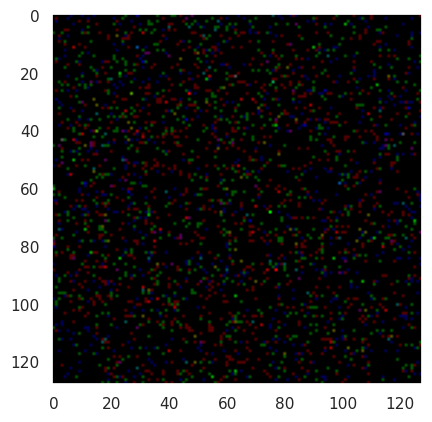

PSNR: -12.433809280395508
True PSNR: -8.05482610996352


In [15]:
ImageNoise, psnr_map, image_target = Train_Dataset.__getitem__(42)
ImageNoise = ImageNoise.detach().cpu().numpy().transpose(1,2,0)
image_target = image_target.detach().cpu().numpy().transpose(1,2,0)
normalised_noisy_image = ImageNoise/ImageNoise.mean()
normalised_image_target = image_target/image_target.mean()
true_psnr = psnr(normalised_image_target, normalised_noisy_image, data_range = normalised_image_target.max() - normalised_image_target.min())
normalised_image_target = (image_target - image_target.min())/(image_target.max() - image_target.min())
normalised_noisy_image = (ImageNoise - ImageNoise.min())/(ImageNoise.max() - ImageNoise.min())
plt.imshow(normalised_noisy_image)
plt.show()
print(f"PSNR: {psnr_map.min().detach().cpu().numpy()}")
print(f"True PSNR: {true_psnr}")

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

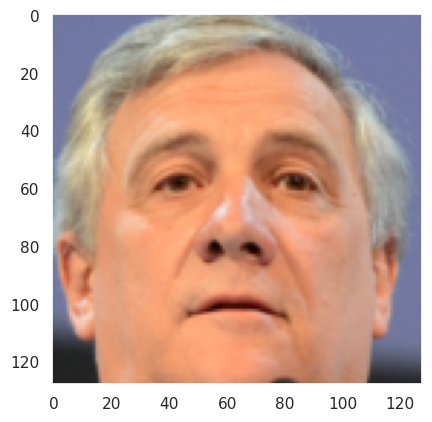

In [16]:
plt.imshow(normalised_image_target)
plt.show()

In [17]:
# Grabs the Validation Paths for the Validation Noisy Images, PSNR Maps and Target Images.
Noisy_Images_Paths = []
Psnr_Maps_Paths = []
Image_Targets_Paths = []
with open(r"Validation_File_PathNames/NoisyImageNames.txt", "r") as File:  # Replace with the Dirctory Pathnames are stored in
    for line in File.readlines():
        Noisy_Images_Paths.append(line[:-1])
with open(r"Validation_File_PathNames/Psnr_MapNames.txt", "r") as File:
    for line in File.readlines():
        Psnr_Maps_Paths.append(line[:-1])
with open(r"Validation_File_PathNames/TargetImageNames.txt", "r") as File:
    for line in File.readlines():
        Image_Targets_Paths.append(line[:-1])
len(Noisy_Images_Paths), len(Psnr_Maps_Paths), len(Image_Targets_Paths)

(10, 10, 10)

In [18]:
Validation_Noisy_Images = {}
Validation_Psnr_Maps = {}
Validation_Target_Images = {}
val_Steps = 10
val_minpsnr = -40
val_maxpsnr = 40
val_Spacing = (val_maxpsnr - val_minpsnr) // val_Steps
val_psnr_ranges = [(i, j) for i, j in zip(range(val_minpsnr, val_maxpsnr, val_Spacing), range(val_minpsnr + val_Spacing, val_maxpsnr + val_Spacing, val_Spacing))]
print(len(val_psnr_ranges))
FaceValidators = [ValidationSetGenerator(root_dir= root_path, out_dir=out_dir, names = Paths, minPSNR= val_psnr_ranges[i][0], targetPSNR = val_psnr_ranges[i][1], augment= True, sample_size = 100, grayscale= GREYSCALE, amplification_factor= 1e2) for i in range(len(val_psnr_ranges))]
FaceValidators[0].out_dir
print(val_psnr_ranges)
for index in range(len(val_psnr_ranges)):
    psnr_label = str(val_psnr_ranges[index][0]) + str(val_psnr_ranges[index][1])
    print(f"Loading Validation Data for {index} Val_Dataset at psnr range {psnr_label}")
    FaceValidator = FaceValidators[index]
    File_Path_NI = Noisy_Images_Paths[index]
    File_Path_PSM = Psnr_Maps_Paths[index]
    File_Path_TI = Image_Targets_Paths[index]
    Noisy_Images, Psnr_Maps, Target_Images = FaceValidator.Load_Noisy_Faces(File_Path_NI, File_Path_PSM, File_Path_TI, device=device)
    Validation_Noisy_Images[psnr_label] = Noisy_Images
    Validation_Psnr_Maps[psnr_label] = Psnr_Maps
    Validation_Target_Images[psnr_label] = Target_Images
len(Validation_Noisy_Images), len(Validation_Psnr_Maps), len(Validation_Target_Images)

10
[(-40, -32), (-32, -24), (-24, -16), (-16, -8), (-8, 0), (0, 8), (8, 16), (16, 24), (24, 32), (32, 40)]
Loading Validation Data for 0 Val_Dataset at psnr range -40-32


/home/linux/KaylenGAP/MScGAPProject/PoissonValidator2.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Noisy_Images = torch.load(file_path_NI)
/home/linux/KaylenGAP/MSc

Loading Validation Data for 1 Val_Dataset at psnr range -32-24
Loading Validation Data for 2 Val_Dataset at psnr range -24-16
Loading Validation Data for 3 Val_Dataset at psnr range -16-8
Loading Validation Data for 4 Val_Dataset at psnr range -80
Loading Validation Data for 5 Val_Dataset at psnr range 08
Loading Validation Data for 6 Val_Dataset at psnr range 816
Loading Validation Data for 7 Val_Dataset at psnr range 1624
Loading Validation Data for 8 Val_Dataset at psnr range 2432
Loading Validation Data for 9 Val_Dataset at psnr range 3240


(10, 10, 10)

In [19]:
Validation_Noisy_Images.keys()

dict_keys(['-40-32', '-32-24', '-24-16', '-16-8', '-80', '08', '816', '1624', '2432', '3240'])

In [20]:
ValidationNoisyTest_Batch = torch.zeros((len(Validation_Noisy_Images), 3, 128, 128))
ValidationPsnrTest_Batch = torch.zeros((len(Validation_Noisy_Images), 3, 128, 128))
ValidationTargetTest_Batch = torch.zeros((len(Validation_Noisy_Images), 3, 128, 128))
for index, key in enumerate(Validation_Noisy_Images.keys()):
    ValidationNoisyTest_Batch[index] = Validation_Noisy_Images[key][-10]
    ValidationPsnrTest_Batch[index] = Validation_Psnr_Maps[key][-10].view(1, 3, 128, 128)
    ValidationTargetTest_Batch[index] = Validation_Target_Images[key][-10]
ValidationNoisyTest_Batch.shape, ValidationPsnrTest_Batch.shape, ValidationTargetTest_Batch.shape

(torch.Size([10, 3, 128, 128]),
 torch.Size([10, 3, 128, 128]),
 torch.Size([10, 3, 128, 128]))

In [21]:
ValidationNoisyTest_Batch = ValidationNoisyTest_Batch.to(device)
ValidationPsnrTest_Batch = ValidationPsnrTest_Batch.to(device)
ValidationTargetTest_Batch = ValidationTargetTest_Batch.to(device)

In [22]:
from GatedDynamicUNet_Final import DynamicGatedUNet
name = "FaceGenerationFinalDynamicConvolutionResUNet-m40-32"
CHECKPOINT_PATH = "./models/"

levels = 10
channels = 3
depth = 5
start_filts = 50
merge_mode = 'concat'
num_layers = 1
activation = nn.SiLU()
dropout_rate = 0.1
learning_rate = 1e-3
weight_decay = 1e-5
batch_size = 32
max_epochs = max_epochs
mini_batches = 512
warm_up_epochs = 10
start_temperature = 20
final_temperature = 1
warm_temperature_epochs = 10
reduction_factor = 16
num_kernels = 4
up_mode = "upsample"
epochs = 60
num_blocks_per_layer = 1
alpha = 0.2
teacher_model = None

model = DynamicGatedUNet(levels = levels, channels = channels, depth = depth,
                         up_mode = up_mode, merge_mode = merge_mode, 
                         num_layers = num_layers, activation = activation,
                         dropout_rate = dropout_rate, learning_rate = learning_rate,
                         weight_decay = weight_decay, starting_filters = start_filts,
                         num_blocks_per_layer = num_blocks_per_layer, epochs = epochs,
                         warm_up_epochs = warm_up_epochs, device = device, mini_batches = mini_batches,
                         start_temperature = start_temperature, final_temperature = final_temperature,
                         num_kernels = num_kernels, teacher_model = teacher_model,
                         alpha = alpha).to(device)
model

/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation'])`.
/home/linux/KaylenGAP/MScGAPProject/GatedDynamicUNet_Final.py:620: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  init.kaiming_normal(m.weight, nonlinearity = "leaky_relu")
/home/linux/KaylenGAP/MScGAPProject/GatedDynamicUNet_Final.py:622: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  init.constant(m.bias, 0)
/home/linux/KaylenGAP/MScGAPProject/GatedDynamicUNet_Final.py:625: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  init.constant(m.weight, 1)
/home/linux/KaylenGAP/MScGAPProject/GatedDynamicUNet_Final.py:626: FutureWarning: `nn.init.constant` is now deprecate

DynamicGatedUNet(
  (activation): SiLU()
  (encoder): ModuleList(
    (0): DownConvolutionBlock(
      (activation): SiLU()
      (Skip_Block): Sequential(
        (0): Conv2d(30, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(10, 50, eps=1e-05, affine=True)
        (2): SiLU()
      )
      (Main_Processing_Block): Dynamic_Sequential(
        (layers): ModuleList(
          (0): DynamicConv2d(
            (Attention): Attention_Block(
              (Dense): Linear(in_features=50, out_features=3, bias=True)
              (Dense_2): Linear(in_features=3, out_features=4, bias=True)
              (GlobalPool): AdaptiveAvgPool2d(output_size=(1, 1))
            )
          )
          (1): GroupNorm(10, 50, eps=1e-05, affine=True)
          (2): SiLU()
          (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): GroupNorm(10, 50, eps=1e-05, affine=True)
          (5): SiLU()
        )
      )
      (pool): MaxPool2d(kernel_si

In [31]:
# Set the configuration 
hyperparameters = {
        "learning_rate": learning_rate,
        "epochs": max_epochs,
        "batch_size": Batch_Size,
        "root_path": root_path,
        "out_dir": out_dir,
        "load_pretained": load_pretained,
        "max_epochs": max_epochs,
        "patience": patience,
        "minpsnr": minpsnr,
        "maxpsnr": maxpsnr,
        "device":"cuda",
        "seed": seed,
        "GREYSCALE":GREYSCALE,
        "NUM_Features": NUM_Features,
        "num_conditions": 5,
        "n_channels": 64, 
        "activation": "LeakyReLU",
        "dropout_rate": 0.3,
        "amplification_factor": 1e3,
        "virtSize": 512*Batch_Size
    }

In [32]:
# Initialize wandb logger
wandb_logger = WandbLogger(
    project="GAP_Model_CrossAttnUNet",
    log_model=True,  # Log checkpoints and best model
    config = hyperparameters
)

In [33]:
# Assuming wandb_logger and other necessary variables are already defined
Trainer = pL.Trainer(
    default_root_dir=os.path.join(CHECKPOINT_PATH, name),
    gradient_clip_val=1.0,
    accelerator="gpu", 
    devices=[0],
    #precision=16,  # Use 16-bit precision (mixed precision) for faster training
    max_epochs=max_epochs,
    logger=wandb_logger,
    enable_checkpointing=False,  # Disable automatic checkpointing
    callbacks=[
        # Uncomment the ModelCheckpoint if you want to save the model
        # ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
        LearningRateMonitor(logging_interval="epoch"),  # Log learning rate every epoch
        EarlyStopping(monitor='val_loss', patience=15)  # Stop training early if no improvement
    ]
)
Trainer.fit(model, Train_Loader, Validation_Loader)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | activation       | SiLU       | 0      | train
1 | encoder          | ModuleList | 27.2 M | train
2 | Bottleneck_Block | ModuleList | 81.1 M | train
3 | decoder          | ModuleList | 42.1 M | train
4 | output           | Conv2d     | 153    | train
--------------------------------------------------------
150 M     Trainable params
0         Non-trainable params
150 M     Total params
601.193   Total estimated model params size 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [34]:
Trainer.test(model, Train_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_MSELoss        │   0.061838600784540176    │
│         test_loss         │   -0.07322224229574203    │
│     test_photon_loss      │    -0.1350608617067337    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.07322224229574203,
  'test_photon_loss': -0.1350608617067337,
  'test_MSELoss': 0.061838600784540176}]

In [29]:
Trainer.test(model, Train_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_MSELoss        │    0.06205018609762192    │
│         test_loss         │   -0.07174709439277649    │
│     test_photon_loss      │    -0.133797287940979     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.07174709439277649,
  'test_photon_loss': -0.133797287940979,
  'test_MSELoss': 0.06205018609762192}]

In [35]:
Trainer.test(model, Validation_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_MSELoss        │   0.061722975224256516    │
│         test_loss         │   -0.07415645569562912    │
│     test_photon_loss      │   -0.13587945699691772    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.07415645569562912,
  'test_photon_loss': -0.13587945699691772,
  'test_MSELoss': 0.061722975224256516}]

In [30]:
Trainer.test(model, Validation_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_MSELoss        │    0.06215575709939003    │
│         test_loss         │   -0.07146313786506653    │
│     test_photon_loss      │   -0.13361886143684387    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.07146313786506653,
  'test_photon_loss': -0.13361886143684387,
  'test_MSELoss': 0.06215575709939003}]

In [23]:
name = "FaceGenerationFinalDynamicConvolutionResUNet-m40-32"
CHECKPOINT_PATH = "./models/"
from GatedDynamicUNet_Final import DynamicGatedUNet
model = DynamicGatedUNet.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')
model 

/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


DynamicGatedUNet(
  (activation): SiLU()
  (encoder): ModuleList(
    (0): DownConvolutionBlock(
      (activation): SiLU()
      (Skip_Block): Sequential(
        (0): Conv2d(30, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(10, 50, eps=1e-05, affine=True)
        (2): SiLU()
      )
      (Main_Processing_Block): Dynamic_Sequential(
        (layers): ModuleList(
          (0): DynamicConv2d(
            (Attention): Attention_Block(
              (Dense): Linear(in_features=50, out_features=3, bias=True)
              (Dense_2): Linear(in_features=3, out_features=4, bias=True)
              (GlobalPool): AdaptiveAvgPool2d(output_size=(1, 1))
            )
          )
          (1): GroupNorm(10, 50, eps=1e-05, affine=True)
          (2): SiLU()
          (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): GroupNorm(10, 50, eps=1e-05, affine=True)
          (5): SiLU()
        )
      )
      (pool): MaxPool2d(kernel_si

In [24]:
lpips_model = lpips.LPIPS(net='alex').to(device)

def Generate_Psnr_Scores(model, Noisy_Images, Psnr_Maps, Target_Images):
    model.eval()
    model = model.to(device)
    Noisy_Images = Noisy_Images.to(device)
    Psnr_Maps = Psnr_Maps.to(device)
    Target_Images = Target_Images.to(device)

    Predictions = torch.zeros(Noisy_Images.shape[0], 3, 128, 128).to(device)
    
    # Process batches correctly without slicing errors
    batch_size = 32
    with torch.no_grad():
        for i in range(0, Noisy_Images.shape[0], batch_size):
            batch_end = min(i + batch_size, Noisy_Images.shape[0])  # Ensure no overflow
            Predictions[i:batch_end] = model(Noisy_Images[i:batch_end]).detach()

        # Adjust predictions after getting model output
        Predictions = torch.exp(Predictions - Predictions.max())  # Handle exp safely to avoid overflow
        Predictions = Noisy_Images.detach().sum(dim=(1, 2, 3), keepdim=True) * Predictions / Predictions.sum(dim=(1, 2, 3), keepdim=True)
        
        perceptual_score = lpips_model(Target_Images, Predictions)
        perceptual_score = 1 - perceptual_score
        
        # Move everything to CPU for further processing
        Noisy_Images = Noisy_Images.cpu().numpy()
        Target_Images = Target_Images.cpu().numpy()
        Predictions = Predictions.cpu().numpy()
        perceptual_score = perceptual_score.cpu().numpy()

        # Normalize Predictions correctly
        Predictions = Predictions / Predictions.mean(axis=(1, 2, 3), keepdims=True)
        
        # Compute PSNR and SSIM scores
        Psnr_Scores = [psnr(Target_Image, Prediction, data_range=Target_Image.max() - Target_Image.min()) for Target_Image, Prediction in zip(Target_Images, Predictions)]
        SSIM_Scores = [ssim(Target_Image, Prediction, data_range=Target_Image.max() - Target_Image.min(), channel_axis=0) for Target_Image, Prediction in zip(Target_Images, Predictions)]
        
        return Psnr_Scores, SSIM_Scores, perceptual_score.reshape(-1,)

Psnr_Distribution = []
SSIM_Distribution = []
Perceptual_Distribution = []

for key in Validation_Noisy_Images.keys():
    if key == "3240":
        continue
    print(key)
    Psnr_Scores, SSIM_Scores, Perceptual_Scores = Generate_Psnr_Scores(model, Validation_Noisy_Images[key], Validation_Psnr_Maps[key], Validation_Target_Images[key])
    Psnr_Distribution.extend(Psnr_Scores)
    SSIM_Distribution.extend(SSIM_Scores)
    Perceptual_Distribution.extend(Perceptual_Scores)

Psnr_Distribution = np.array(Psnr_Distribution)
SSIM_Distribution = np.array(SSIM_Distribution)
Perceptual_Distribution = np.array(Perceptual_Distribution)
Psnr_Distribution.shape, SSIM_Distribution.shape, Perceptual_Distribution.shape

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
-40-32


/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/linux/anaconda3/envs/GAPProject/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during u

-32-24
-24-16
-16-8
-80
08
816
1624
2432


((900,), (900,), (900,))

,PSNR,Pseudo_PSNR,PSNR_Average,PSNR_Variance,PSNR_Variance_Upper,PSNR_Variance_Lower
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,23.867597,-3.559511,23.755012,1.542971,25.297984,22.212041
std,7.523076,20.564969,7.378114,0.450204,7.540512,7.240109
min,9.872512,-39.119021,12.968252,0.728565,14.281014,11.349283
25%,17.004387,-21.339266,16.823376,1.228967,18.102743,15.437684
50%,23.630127,-3.559511,23.303993,1.427243,24.682377,22.000176
75%,30.590146,14.220245,30.643581,1.783137,32.638971,28.630694
max,38.722641,32.000000,35.738090,3.090397,38.157969,34.399237


,SSIM,Pseudo_PSNR,SSIM_Average,SSIM_Variance,SSIM_Variance_Upper,SSIM_Variance_Lower
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.683867,-3.559511,0.680118,0.050139,0.730257,0.629979
std,0.230411,20.564969,0.224658,0.024776,0.208115,0.242608
min,0.186000,-39.119021,0.324954,0.006734,0.390952,0.257008
25%,0.466561,-21.339266,0.444706,0.026401,0.510013,0.379400
50%,0.708848,-3.559511,0.702482,0.054295,0.764080,0.639558
75%,0.913308,14.220245,0.905003,0.069855,0.938315,0.864658
max,0.982822,32.000000,0.971815,0.099834,1.033110,0.964679


,1-PL,Pseudo_PSNR,1-PL_Average,1-PL_Variance,1-PL_Variance_Upper,1-PL_Variance_Lower
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,0.469221,-3.119021,0.465653,0.053664,0.475107,0.456200
std,0.305772,20.310653,0.301226,0.022087,0.304236,0.298340
min,-0.052558,-38.238042,0.094518,0.010774,0.097046,0.090356
25%,0.130228,-20.678532,0.122645,0.033144,0.126180,0.118675
50%,0.615262,-3.119021,0.672692,0.056745,0.690053,0.652468
75%,0.753334,14.440489,0.733633,0.072143,0.744609,0.723617
max,0.927568,32.000000,0.873106,0.104886,0.882070,0.864867


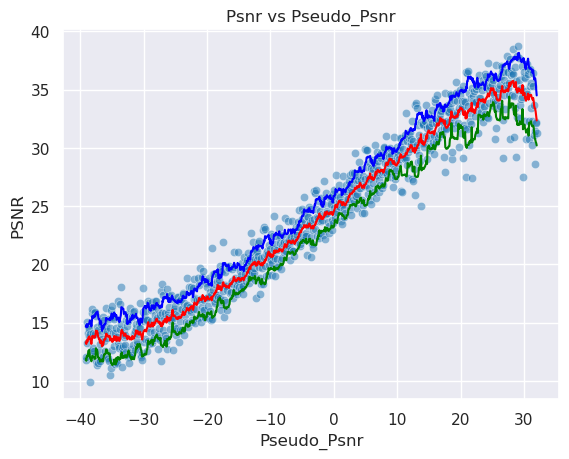

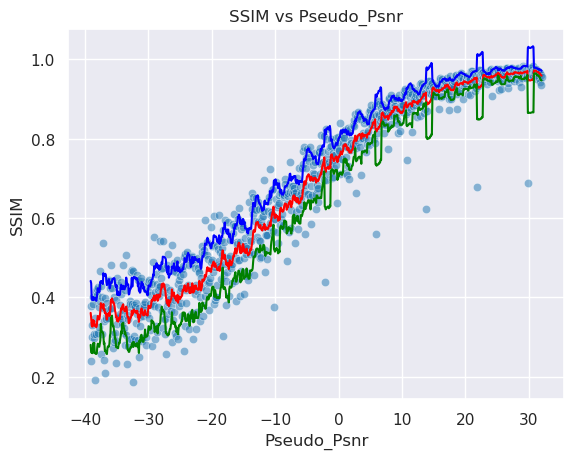

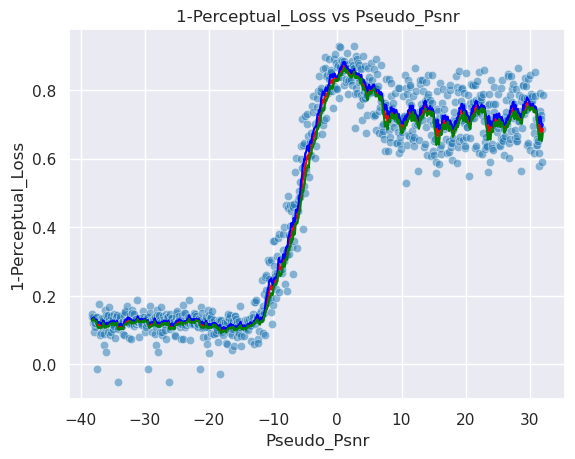

Psnr Area: 1689.5082220978834, SSIM Area: 48.37096435826135, Perceptual Area: 32.711187170066346
Mean Psnr 23.867596933756396
Std Psnr 7.523076085418084
Min Psnr 9.87251216252771
Max Psnr 38.72264077961675
Mean Roll Var 1.5429713936075904
Mean SSIM 0.6838673
Std SSIM 0.23041054606437683
Min SSIM 0.18600040674209595
Max SSIM 0.9828217625617981
Mean Roll SSIM 0.05013915365043618
Mean 1-PL 0.46922052
Std 1-PL 0.30577245354652405
Min 1-PL -0.05255842208862305
Max 1-PL 0.9275684952735901
Mean Roll 1-PL 0.05366400749463533


(1689.5082220978834, 48.37096435826135, 32.711187170066346)

In [25]:
Plot_Creater(Psnr_Distribution, SSIM_Distribution, Perceptual_Distribution, minpsnr, maxpsnr)

In [27]:
np.save("Data/Psnr_Distribution_13.npy", Psnr_Distribution)
np.save("Data/SSIM_Distribution_13.npy", SSIM_Distribution)
np.save("Data/Perceptual_Distribution_13.npy", Perceptual_Distribution)

In [22]:
from GatedConditionalDynamicUNet_Final import DynamicGatedUNet
name = "FaceGenerationFinalConditionalDynamicConvolutionResUNet-m40-32"
CHECKPOINT_PATH = "./models/"

levels = 10
channels = 3
depth = 5
start_filts = 42
merge_mode = 'concat'
num_layers = 1
activation = nn.LeakyReLU()
dropout_rate = 0.1
learning_rate = 1e-3
weight_decay = 1e-5
batch_size = 32
max_epochs = 30
mini_batches = 512
warm_up_epochs = 10
start_temperature = 20
final_temperature = 1
warm_temperature_epochs = 10
reduction_factor = 16
num_kernels = 4
up_mode = "upsample"
epochs = 30
num_blocks_per_layer = 1
embedding_size = 32

model = DynamicGatedUNet(levels = levels, channels = channels, depth = depth,
                         up_mode = up_mode, merge_mode = merge_mode, 
                         num_layers = num_layers, activation = activation,
                         dropout_rate = dropout_rate, learning_rate = learning_rate,
                         weight_decay = weight_decay, starting_filters = start_filts,
                         num_blocks_per_layer = num_blocks_per_layer, epochs = epochs,
                         warm_up_epochs = warm_up_epochs, mini_batches = mini_batches,
                         start_temperature = start_temperature, final_temperature = final_temperature,
                         num_kernels = num_kernels, embedding_dim  = embedding_size).to(device)
model

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation'])`.
c:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\GatedConditionalDynamicUNet_Final.py:632: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight, nonlinearity = "leaky_relu")
c:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\GatedConditionalDynamicUNet_Final.py:634: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
c:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\GatedConditionalDynamicUNet_Final.py:637: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.weight, 1)
c:\

DynamicGatedUNet(
  (activation): LeakyReLU(negative_slope=0.01)
  (encoder): ModuleList(
    (0): DownConvolutionBlock(
      (activation): LeakyReLU(negative_slope=0.01)
      (Skip_Block): Sequential(
        (0): Conv2d(30, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(7, 42, eps=1e-05, affine=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (Main_Processing_Block): Dynamic_Sequential(
        (layers): ModuleList(
          (0): DynamicConv2d(
            (Attention): Attention_Block(
              (Dense): Linear(in_features=74, out_features=2, bias=True)
              (Dense_2): Linear(in_features=2, out_features=4, bias=True)
              (GlobalPool): AdaptiveAvgPool2d(output_size=(1, 1))
            )
          )
          (1): GroupNorm(7, 42, eps=1e-05, affine=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): GroupNorm(7, 42, eps=

In [23]:
# Set the configuration 
hyperparameters = {
        "learning_rate": learning_rate,
        "epochs": max_epochs,
        "batch_size": Batch_Size,
        "root_path": root_path,
        "out_dir": out_dir,
        "load_pretained": load_pretained,
        "max_epochs": max_epochs,
        "patience": patience,
        "minpsnr": minpsnr,
        "maxpsnr": maxpsnr,
        "device":"cuda",
        "seed": seed,
        "GREYSCALE":GREYSCALE,
        "NUM_Features": NUM_Features,
        "num_conditions": 5,
        "n_channels": 64, 
        "activation": "LeakyReLU",
        "dropout_rate": 0.3,
        "amplification_factor": 1e3,
        "virtSize": 512*Batch_Size
    }

In [24]:
# Initialize wandb logger
wandb_logger = WandbLogger(
    project="GAP_Model_CrossAttnUNet",
    log_model=True,  # Log checkpoints and best model
    config = hyperparameters
)

In [25]:
# Assuming wandb_logger and other necessary variables are already defined
Trainer = pL.Trainer(
    default_root_dir=os.path.join(CHECKPOINT_PATH, name),
    gradient_clip_val=0.5,
    accelerator="gpu", 
    devices=[0],
    #precision=16,  # Use 16-bit precision (mixed precision) for faster training
    max_epochs=max_epochs,
    logger=wandb_logger,
    enable_checkpointing=False,  # Disable automatic checkpointing
    callbacks=[
        # Uncomment the ModelCheckpoint if you want to save the model
        # ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
        LearningRateMonitor(logging_interval="epoch"),  # Log learning rate every epoch
        EarlyStopping(monitor='val_loss', patience=10)  # Stop training early if no improvement
    ]
)
Trainer.fit(model, Train_Loader, Validation_Loader)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kaylendarnbrook. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type       | Params
------------------------------------------------
0 | activation       | LeakyReLU  | 0     
1 | encoder          | ModuleList | 19.2 M
2 | Embedding        | Sequential | 1.2 K 
3 | Bottleneck_Block | ModuleList | 57.2 M
4 | decoder          | ModuleList | 29.7 M
5 | output           | Conv2d     | 129   
------------------------------------------------
106 M     Trainable params
0         Non-trainable params
106 M     Total params
424.667   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [26]:
# # Validates the trained model on the Train Set for the Trainer object
Trainer.test(model, Train_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_MSELoss        │    0.06186030060052872    │
│         test_loss         │   -0.07214295119047165    │
│     test_photon_loss      │   -0.13400328159332275    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.07214295119047165,
  'test_photon_loss': -0.13400328159332275,
  'test_MSELoss': 0.06186030060052872}]

In [27]:
Trainer.test(model, Validation_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_MSELoss        │    0.06266535818576813    │
│         test_loss         │   -0.07058130949735641    │
│     test_photon_loss      │   -0.13324667513370514    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.07058130949735641,
  'test_photon_loss': -0.13324667513370514,
  'test_MSELoss': 0.06266535818576813}]

In [29]:
# Generates the Psnr, SSIM and Perceptual Loss Scores of the model on the Validation Set for the Trainer object
lpips_model = lpips.LPIPS(net='alex').to(device)
def Generate_Psnr_Scores(model, Noisy_Images, Psnr_Maps, Target_Images):
    model = model.to(device)
    Noisy_Images = Noisy_Images.to(device)
    Psnr_Maps = Psnr_Maps.to(device)
    Target_Images = Target_Images.to(device)

    Predictions = model(Noisy_Images, Psnr_Maps).detach().cpu()
    Predictions -= Predictions.max()
    Predictions = torch.exp(Predictions)
    Predictions = Noisy_Images.detach().cpu().sum() * Predictions/Predictions.sum()
    perceptual_score = lpips_model(Target_Images, Predictions.to(device))
    perceptual_score = 1 - perceptual_score
    #print(perceptual_score)

    Noisy_Images = Noisy_Images.detach().cpu().numpy()
    Target_Images = Target_Images.detach().cpu().numpy()
    Predictions = Predictions.detach().cpu().numpy()
    perceptual_score = perceptual_score.detach().cpu().numpy()

    Predictions = Predictions/Predictions.mean(axis = (1,2,3), keepdims=True) 
    #Target_Images = Target_Images/Target_Images.mean(axis = (1,2,3), keepdims=True)
    
    Psnr_Scores = [psnr(Target_Image, Prediction, data_range = Target_Image.max() - Target_Image.min()) for Target_Image, Prediction in zip(Target_Images, Predictions)]
    SSIM_Scores = [ssim(Target_Image, Prediction, data_range = Target_Image.max() - Target_Image.min(), channel_axis=0) for Target_Image, Prediction in zip(Target_Images, Predictions)]
    #lpips_score = lpips.lpips(Predictions, Target_Images)
    return Psnr_Scores, SSIM_Scores, perceptual_score.reshape(-1,)

Psnr_Distribution = []
SSIM_Distribution = []
Perceptual_Distribution = []
for key in Validation_Noisy_Images.keys():
    if key == "3240":
        continue
    print(key)
    Psnr_Scores, SSIM_Scores, Perceptual_Scores = Generate_Psnr_Scores(model, Validation_Noisy_Images[key], Validation_Psnr_Maps[key], Validation_Target_Images[key])
    Psnr_Distribution.extend(Psnr_Scores)
    SSIM_Distribution.extend(SSIM_Scores)
    Perceptual_Distribution.extend(Perceptual_Scores)
Psnr_Distribution_2 = np.array(Psnr_Distribution)
SSIM_Distribution_2 = np.array(SSIM_Distribution)
Perceptual_Distribution_2 = np.array(Perceptual_Distribution)
Psnr_Distribution_2.shape, SSIM_Distribution_2.shape, Perceptual_Distribution_2.shape

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\lpips\weights\v0.1\alex.pth
-40-32
-32-24
-24-16
-16-8
-80
08
816
1624
2432


((900,), (900,), (900,))

,PSNR,Pseudo_PSNR,PSNR_Average,PSNR_Variance,PSNR_Variance_Upper,PSNR_Variance_Lower
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,22.709988,-3.559511,22.618509,1.452788,24.071297,21.165722
std,6.228345,20.564969,6.082457,0.380704,6.092311,6.096407
min,9.687190,-39.119021,13.035960,0.648800,14.393153,11.341978
25%,17.024718,-21.339266,16.863024,1.174576,18.190915,15.359770
50%,22.950931,-3.559511,22.846973,1.385164,24.197087,21.494573
75%,28.488845,14.220245,28.607138,1.701602,30.553172,27.025640
max,33.702844,32.000000,31.381554,2.689983,32.985458,30.510057


,SSIM,Pseudo_PSNR,SSIM_Average,SSIM_Variance,SSIM_Variance_Upper,SSIM_Variance_Lower
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.627583,-3.559511,0.624290,0.055774,0.680064,0.568516
std,0.211407,20.564969,0.203168,0.028809,0.196737,0.213329
min,0.183457,-39.119021,0.309273,0.013039,0.369308,0.246890
25%,0.429480,-21.339266,0.420882,0.037944,0.476683,0.345886
50%,0.648391,-3.559511,0.638480,0.050659,0.695209,0.572498
75%,0.834684,14.220245,0.826691,0.065223,0.879010,0.776591
max,0.932737,32.000000,0.897945,0.156096,1.002684,0.882356


,1-PL,Pseudo_PSNR,1-PL_Average,1-PL_Variance,1-PL_Variance_Upper,1-PL_Variance_Lower
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,0.458056,-3.119021,0.454734,0.055354,0.464760,0.444708
std,0.290843,20.310653,0.285351,0.027889,0.289287,0.282094
min,-0.052512,-38.238042,0.099204,0.010919,0.101961,0.093206
25%,0.134201,-20.678532,0.125003,0.036514,0.128353,0.121433
50%,0.608728,-3.119021,0.662325,0.055454,0.676454,0.646639
75%,0.725056,14.440489,0.704805,0.070782,0.715762,0.696593
max,0.891318,32.000000,0.805083,0.250146,0.815006,0.796856


c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

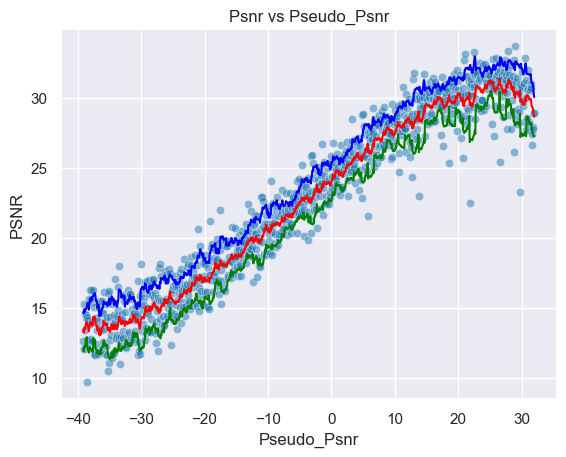

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

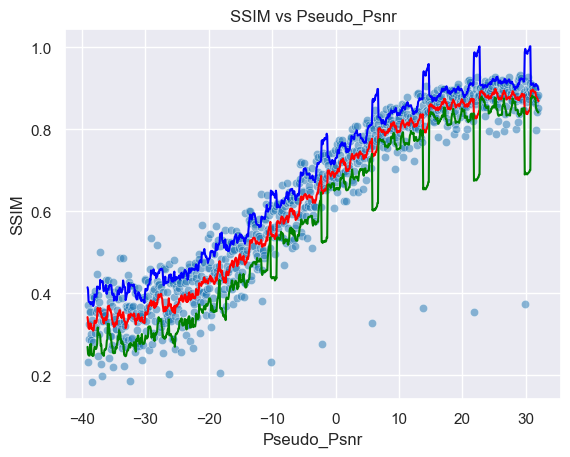

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

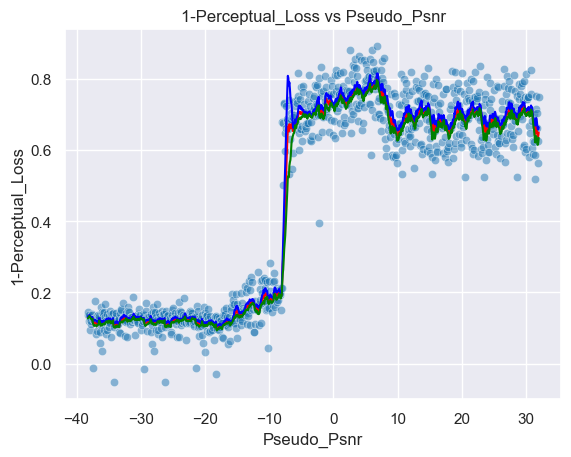

Psnr Area: 1608.7330966620816, SSIM Area: 44.40038907854456, Perceptual Area: 31.94484615982308
Mean Psnr 22.709988025590757
Std Psnr 6.228345435024213
Min Psnr 9.68718985435964
Max Psnr 33.70284386687155
Mean Roll Var 1.4527876278601093
Mean SSIM 0.62758297
Std SSIM 0.21140678226947784
Min SSIM 0.1834569126367569
Max SSIM 0.9327372908592224
Mean Roll SSIM 0.055774436841250316
Mean 1-PL 0.45805565
Std 1-PL 0.2908426821231842
Min 1-PL -0.05251169204711914
Max 1-PL 0.8913182020187378
Mean Roll 1-PL 0.05535401810103648


(1608.7330966620816, 44.40038907854456, 31.94484615982308)

In [30]:
## Generates the dataframes for the Psnr, SSIM and Perceptual Loss, and produces their plots for the model
Plot_Creater(Psnr_Distribution_2, SSIM_Distribution_2, Perceptual_Distribution_2, minpsnr, maxpsnr)